# Prediction

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [2]:
data_folder = "data"
img_shape = 28, 28
nb_classes = 26

In [3]:
# from src.constants import data_folder, img_shape
from src.utils import init_notebook

In [4]:
init_notebook()

In [5]:
df = pd.read_csv(f"{data_folder}/raw/original-dataset.csv", header=None)

## 2. Modèle de RandomForest

### Stratégie d'évaluation

On se propose d'utiliser une StratifiedKFold : 
- on utilise la cross-validation (plus fiable que le train/test split)
- on utilise la stratégie KFold (plusieurs passes sur le jeu de données donc une estimation plus fiable)
- on mélange aléatoirement les données ("shuffle") pour éviter un éventuel tri des données initiales (ce qui induirait un fort biais, les données $i$ et $i+1$ pourraient être corrélées si elles étaient triées, et chaque fold pourrait n'être confronté qu'à une seule classe au lieu des 10 dans le pire des cas)
- c'est une méthode très adaptée à un jeu de données avec plusieurs classes : en effet, la version stratifiée permet de respecter la répartition des classes, ce qui est d'autant plus utile que les classes sont déséquilibrées. Ici les classes sont équilibrées donc l'avantage est moindre mais la version stratifiée est théoriquement meilleure.

In [6]:
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split

In [7]:
def strategie_evaluation(seed: int = 0, n_splits: int = 5):
    """Crée notre stratégie d'évaluation"""
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    return kfold

In [8]:
kfold = strategie_evaluation(n_splits=2)  # 2 splits car contrainte de temps durant l'examen

### Métrique

Nous proposons d'utiliser l'accuracy.

Afin de comparer nos modèles, nous établissons un score "naïf" à l'aide d'un DummyClassifier : celui-ci va permettre de tester le score qu'obtiendrait un modèle qui _ignore_ les données et choisit uniformément parmi les 10 classes disponibles.

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier

In [10]:
dummy = DummyClassifier(strategy="uniform", random_state=0)

### Création du x et du y

In [11]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [13]:
# vérifions les shapes
print(f"{X_train.shape = }")
print(f"{y_train.shape = }")
print(f"{X_test.shape = }")
print(f"{y_test.shape = }")

X_train.shape = (279028, 784)
y_train.shape = (279028,)
X_test.shape = (93010, 784)
y_test.shape = (93010,)


### Fonction de cross-validation

In [14]:
from sklearn.metrics import make_scorer # pour convertir la fonction métrique pour sklearn


def cross_validation(model, x, y, strategie_cv, metrique, experimentation: bool = False):
    """Effectue une validation croisée sur le modèle `model`"""

    if experimentation:  # pour expérimenter rapidement
        nouveau_x = x.sample(30)
        nouveau_y = y.sample(30)
    else:
        nouveau_x = x
        nouveau_y = y

    scores = cross_validate(
        model,
        nouveau_x,
        nouveau_y,
        cv=strategie_cv,
        scoring=make_scorer(metrique),
        n_jobs=-2,  # pour tourner en parallèle, "-1" indique "utilise tous les CPUs disponibles"
    )

    return scores

### 1er modèle (hyper-paramètres par défaut)

In [17]:
rf_defaut = RandomForestClassifier(random_state=0, n_jobs=-2)

In [18]:
from time import time

debut = time()

rf_defaut.fit(X_train, y_train)

fin = time()
print(f"temps de calcul {round(fin - debut, 2)} s")

temps de calcul 37.43 s


In [ ]:
198

In [26]:
full_test_dataset_path = "data/raw/test-dataset.csv"
sample_test_dataset_path = "data/raw/sample-test-dataset.csv"

In [29]:
# Open full test dataset if it exists locally, open sample test dataset otherwise

if os.path.exists(full_test_dataset_path):
    test_dataset = np.loadtxt(full_test_dataset_path, delimiter=",")
else:
    test_dataset = np.loadtxt(sample_test_dataset_path, delimiter=",")

In [19]:
y_pred = rf_defaut.predict(X_test)

In [37]:
y_pred_convert = list(map(np.argmax, y_pred))

In [20]:
letters = [chr(i) for i in range(ord("a"), ord("z") + 1)]

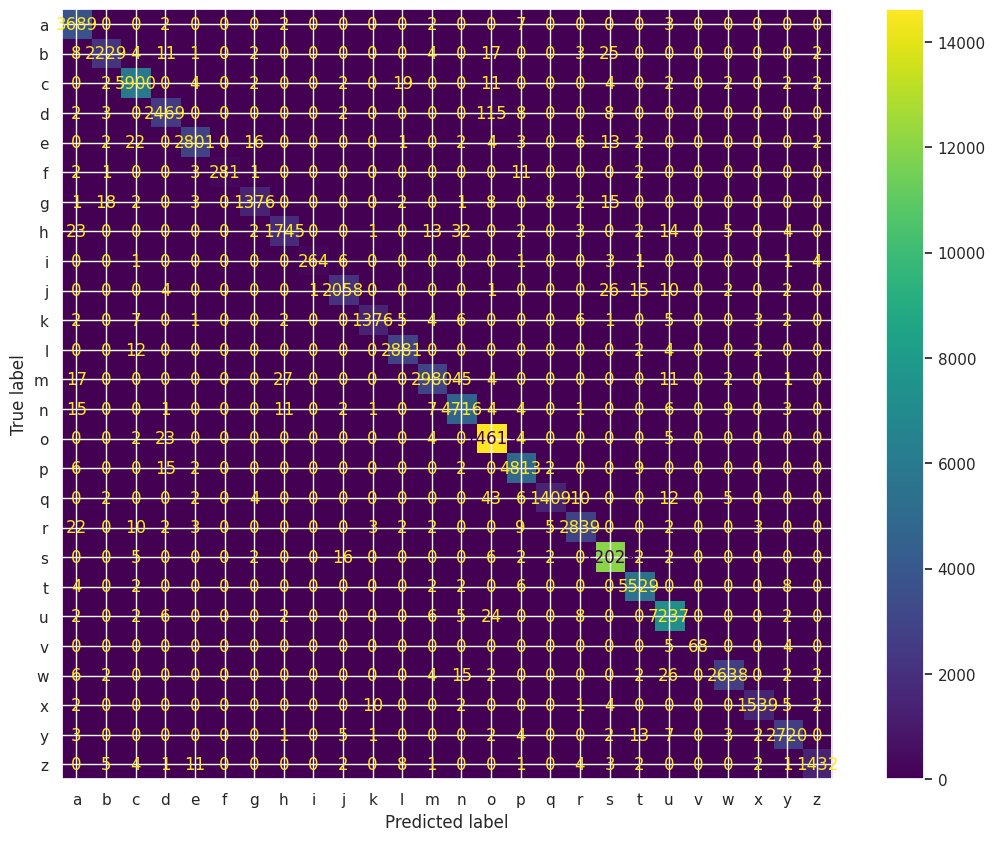

In [21]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=letters)

fig, ax = plt.subplots(figsize=(14, 10))
disp.plot(ax=ax)
# plt.savefig(f"{model_results_folder}/confusion_matrix.png")
plt.show()